In [1]:
%load_ext autoreload
%autoreload 2
import base64
import glob
import time
import os
import io

import numpy as np

from PIL import Image

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import requests

from IPython.core.display import display, HTML
from IPython.display import clear_output

from agea_captcha import captcha

/Users/sw/.virtualenvs/notebook36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [350]:
captcha.extract_data('../captchas.txt', recreate=True)

In [351]:
image_path = 'data/images.npy'
label_path = 'data/labels.npy'

In [352]:
images = np.load(image_path)
labels = np.load(label_path)

TOTAL_SIZE = len(images)
VALIDATION_SIZE = int(TOTAL_SIZE / 5)
TEST_SIZE = int(TOTAL_SIZE / 5)

test_images = images[:TEST_SIZE]
test_labels = labels[:TEST_SIZE]

train_images = images[TEST_SIZE:]
train_labels = labels[TEST_SIZE:]

validation_images = train_images[:VALIDATION_SIZE]
validation_labels = train_labels[:VALIDATION_SIZE]
train_images = train_images[VALIDATION_SIZE:]
train_labels = train_labels[VALIDATION_SIZE:]

In [353]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.5,
        height_shift_range=0.3,
        shear_range=0.4,
        horizontal_flip=False,
        fill_mode='constant',
        cval=1
    )

test_datagen = ImageDataGenerator()

In [269]:
model = captcha.make_model()

In [354]:
train_generator = train_datagen.flow(
    train_images, train_labels,
#     save_to_dir='train_generator'
)
validation_generator = train_datagen.flow(validation_images, validation_labels)

In [355]:
batch_size = 16

keras_tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir='./graph', write_graph=True,
    write_grads=True, write_images=True,
    histogram_freq=0
)

model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
#         validation_data=validation_generator,
        validation_data=(validation_images, validation_labels),
        validation_steps=validation_images.shape[0] // batch_size,
        callbacks=[
#             ModelCheckpoint('models/gtsrb1-{epoch}.hdf5', verbose=1, save_best_only = True),
            keras_tensorboard_callback,
#             EarlyStopping(patience=5, verbose=1),
        ]
)

Epoch 1/50
125/125 [==============================] - 27s 213ms/step - loss: 0.6342 - acc: 0.8084 - val_loss: 0.2211 - val_acc: 0.9358
Epoch 2/50
125/125 [==============================] - 26s 205ms/step - loss: 0.5800 - acc: 0.8174 - val_loss: 0.3486 - val_acc: 0.9083
Epoch 3/50
125/125 [==============================] - 26s 206ms/step - loss: 0.5430 - acc: 0.8229 - val_loss: 0.3034 - val_acc: 0.9174
Epoch 4/50
125/125 [==============================] - 27s 219ms/step - loss: 0.5415 - acc: 0.8279 - val_loss: 0.2978 - val_acc: 0.9021
Epoch 5/50
125/125 [==============================] - 26s 211ms/step - loss: 0.5201 - acc: 0.8368 - val_loss: 0.2308 - val_acc: 0.9297
Epoch 6/50
125/125 [==============================] - 30s 239ms/step - loss: 0.5373 - acc: 0.8275 - val_loss: 0.3459 - val_acc: 0.9113
Epoch 7/50
125/125 [==============================] - 27s 212ms/step - loss: 0.4821 - acc: 0.8443 - val_loss: 0.3223 - val_acc: 0.8960
Epoch 8/50
125/125 [==============================] - 2

In [358]:
model.save_weights('agea_11.h5')

In [305]:
score = model.evaluate_generator(validation_generator)
score

[1.7663684422905381, 0.6858108108108109]

In [2]:
cs = captcha.CaptchaSolver(model_path='agea_11.h5')

In [3]:
def show_predicted(cs):
    response = requests.get('https://www.sian.it/pubbAimu/Captcha.jpg')
    img = Image.open(io.BytesIO(response.content))
    display(img)
    return cs.predict(img)

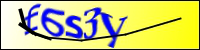

'f6s3y'

In [6]:
show_predicted(cs)